In [1]:
import os

import pandas as pd
import scanpy as sc

In [2]:
data_dir = "../data/Run_S315_(Cortex_AllSynapses)"

In [3]:
# 1. Loading Files and Object Creation
adata = sc.read_10x_mtx(os.path.join(data_dir, "S315_Solo.out/GeneFull/raw"), var_names='gene_symbols', cache=True)
adata.var_names_make_unique()

In [4]:
adata.obs = pd.read_csv(os.path.join(data_dir, "S315_Solo.out/GeneFull/raw/barcodes.tsv"), sep="\t", header=None)

In [5]:
adata.obs.columns = ["barcode"]

In [6]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [7]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [8]:
# remove mitochondrial genes
adata_wo_mit = adata[:, ~adata.var['mt']].copy()

/Users/arturszalata/miniconda3/envs/single-synapse-rna/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
def processing(adata_in, min_genes_threshold = 10,
min_cells_threshold = 50, min_counts_threshold= 20):
    adata = adata_in.copy()
    sc.pp.filter_cells(adata, min_genes=min_genes_threshold)
    # Then, filter out genes that are expressed in fewer than 50 cells
    sc.pp.filter_genes(adata, min_cells=min_cells_threshold)
    # filter cells with fewer than x counts
    sc.pp.filter_cells(adata, min_counts=min_counts_threshold)
    return adata

In [10]:
adata_preprocessed = processing(adata_wo_mit)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_52978/1363717410.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_preprocessed, resolution=0.5)


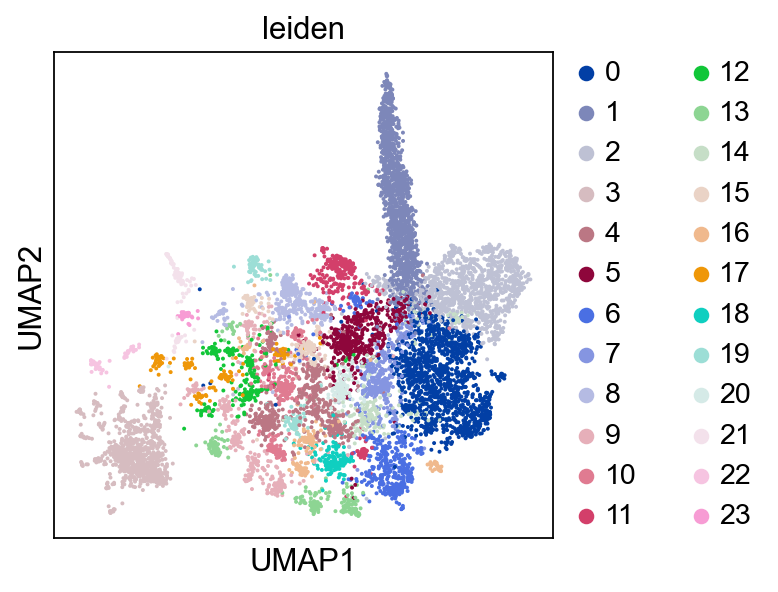

In [11]:
# Normalization and clustering of data
sc.pp.normalize_total(adata_preprocessed, target_sum=1e4)
sc.pp.log1p(adata_preprocessed)

sc.pp.neighbors(adata_preprocessed)
sc.tl.leiden(adata_preprocessed, resolution=0.5)
sc.tl.umap(adata_preprocessed)
sc.pl.umap(adata_preprocessed, color='leiden')

/Users/arturszalata/miniconda3/envs/single-synapse-rna/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/arturszalata/miniconda3/envs/single-synapse-rna/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/arturszalata/miniconda3/envs/single-synapse-rna/lib/python3.10/s

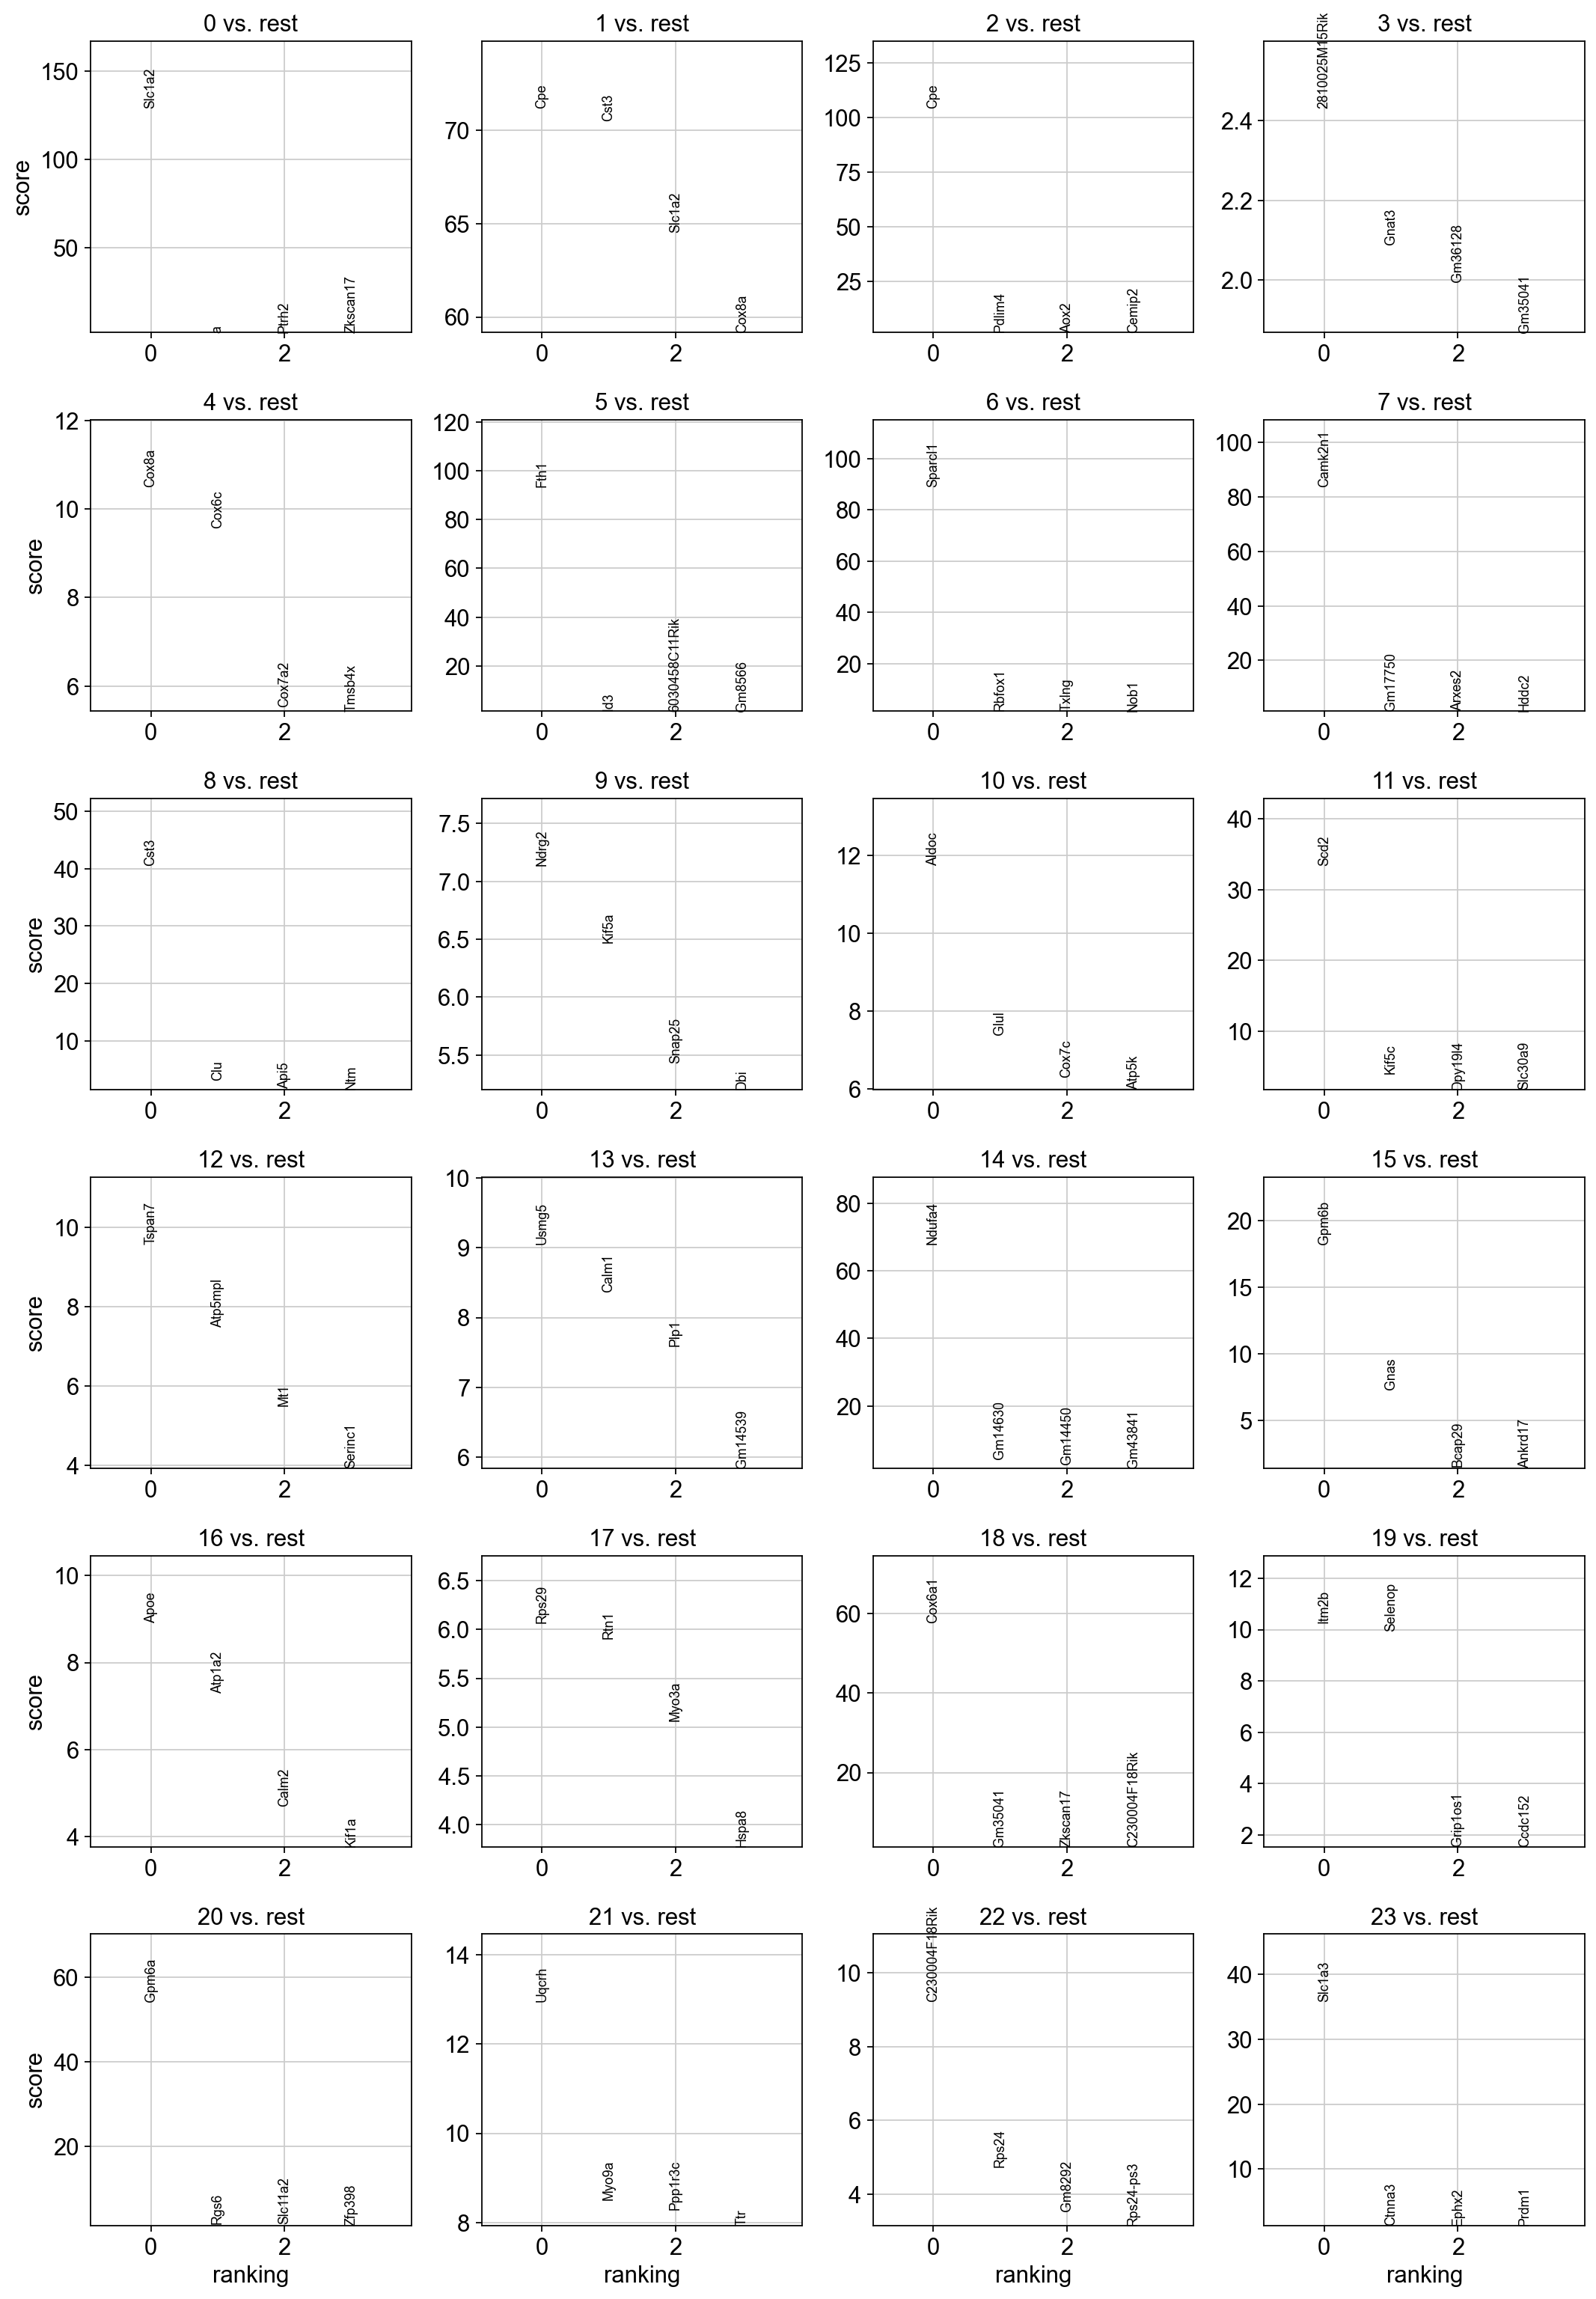

In [12]:
sc.tl.rank_genes_groups(adata_preprocessed, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_preprocessed, n_genes=4, sharey=False)